In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx
import csv
from tqdm import tqdm
import json
import pandas as pd

In [11]:
def read_snapshot(filename, it):
    G = nx.Graph()
    with open(filename, 'r') as runfile:
        its = json.load(runfile)
        edgelist = its[it]['edges']
        opinions = its[it]['status']
        for edge in edgelist:
            G.add_node(int(edge[0])) #superhero in first column
            G.add_node(int(edge[1])) #superhero in second column
            G.add_edge(int(edge[0]), int(edge[1]), weight = 1)
        nx.set_node_attributes(G, {int(k): v for k,v in opinions.items()}, name="opinion")
        return G

def compute_ncc(graph):
    return nx.number_connected_components(graph)

def compute_avgdeg(graph):
    degree = dict(graph.degree())
    s = sum(degree.values())
    return s/graph.number_of_nodes()
    

def compute_triangles(graph):
    d = dict(nx.triangles(graph))
    s = sum(d.values())
    return s/graph.number_of_nodes()

def compute_clustering(graph):
    return nx.average_clustering(graph)

def compute_nac(graph):
    return nx.degree_assortativity_coefficient(graph)

def compute_assortativity(graph):
    
    def homophily(graph, v):
        opv = graph.nodes[v]['opinion']
        degv = graph.degree[v]
        neighborsops = [graph.nodes[u]['opinion'] for u in graph.neighbors(v)]
        neighborsdeg = [graph.degree[u] for u in graph.neighbors(v)]
        E = graph.number_of_edges()
        num = 0
        den = 0
        for i in range(len(neighborsops)):
            num += (1 - ((degv)*neighborsdeg[i])/(2*E))*(opv*neighborsops[i])
            if abs(opv-neighborsops[i]) < 0.001:
                delta = 1
            else:
                delta = 0
            den += ((degv*delta)-((degv)*neighborsdeg[i])/(2*E))*(opv*neighborsops[i])              
        return num/den

    hlist = []
    
    for v in list(G.nodes()):
        hv = homophily(graph, v)
        hlist.append(hv)
    
    return sum(hlist)/len(hlist)

In [12]:
%cd res/

[WinError 2] Impossibile trovare il file specificato: 'res/'
C:\Users\valen\Github\AdaptiveAlgBiasOnSC\res


In [13]:
%ls

 Il volume nell'unit… C Š OS
 Numero di serie del volume: DE13-1B16

 Directory di C:\Users\valen\Github\AdaptiveAlgBiasOnSC\res

24/06/2022  20:03    <DIR>          .
24/06/2022  20:03    <DIR>          ..
27/06/2022  13:14            11.994 metrics rewiring 100 er.csv
22/06/2022  16:55             3.735 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr1.csv
22/06/2022  16:55             4.647 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr10.csv
22/06/2022  16:55             4.065 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr11.csv
22/06/2022  16:55             3.580 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr12.csv
22/06/2022  16:55             3.677 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr13.csv
22/06/2022  16:55             4.356 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr14.csv
22/06/2022  16:55             4.259 metrics rewiring er0.1 pr0.0 e0.35 g0.0 mi1000000 nr15.csv
22/06/2022  16:55             3.968 metrics rewiring er0.1 pr0.0 

In [14]:
modelname = "rewiring"

In [15]:
mi = 1000000

In [7]:
import os
aggrfile = open(f"{modelname} er0.1 metrics.csv", "w+")
header = "model,graph,n,p,pr,eps,gam,max_it\n"
aggrfile.write(header)
aggrfile.close()
aggrfile = open(f"{modelname} er0.1 metrics.csv", "a+")
for graph in ['er']:
    if graph == "er":
        p = 0.1
    else:
        p=5
    for pr in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for eps in [0.35]:
            for gam in [0.0, 0.5, 1.0, 1.5]:
                name = f"{modelname} {graph}{p} pr{pr} e{eps} g{gam} mi1000000"
                s = f"{modelname},{graph},100,{p},{pr},{eps},{gam},1000000\n"
                aggrfile.write(s)
aggrfile.close()
results = pd.read_csv(f"{modelname} er0.1 metrics.csv")

In [10]:
results

,Unnamed: 0,model,graph,n,p,pr,eps,gam,max_it,avgncc_initial,...,avgtri_initial,avgcl_initial,avgass_initial,avghom_initial,avgncc_final,avgavd_final,avgtri_final,avgcl_final,avgass_final,avghom_final
0,0,rewiring,er,100,0.1,0.0,0.35,0.0,1000000,1.000000,...,4.380000,0.096150,0.035124,0.191868,1.000000,1.000000,4.380000,0.096150,0.035124,0.960963
1,1,rewiring,er,100,0.1,0.0,0.35,0.5,1000000,1.000000,...,4.380000,0.096150,0.035124,0.176620,1.000000,1.000000,4.380000,0.096150,0.035124,0.936832
2,2,rewiring,er,100,0.1,0.0,0.35,1.0,1000000,1.000000,...,4.380000,0.096150,0.035124,0.158457,1.000000,1.000000,4.380000,0.096150,0.035124,0.743221
3,3,rewiring,er,100,0.1,0.0,0.35,1.5,1000000,1.000000,...,4.380000,0.096150,0.035124,0.157724,1.000000,1.000000,4.380000,0.096150,0.035124,0.201147
4,4,rewiring,er,100,0.1,0.1,0.35,0.0,1000000,1.300000,...,6.515177,0.142138,0.014098,0.194216,1.500000,1.500000,6.674492,0.145036,0.018650,0.999998
5,5,rewiring,er,100,0.1,0.1,0.35,0.5,1000000,1.000000,...,6.737788,0.146391,0.063024,0.188759,1.000000,1.000000,6.607788,0.143532,0.061563,0.983815
6,6,rewiring,er,100,0.1,0.1,0.35,1.0,1000000,1.000000,...,4.845000,0.112780,0.009134,0.168325,1.000000,1.000000,4.816000,0.112550,0.005865,0.875298
7,7,rewiring,er,100,0.1,0.1,0.35,1.5,1000000,1.000000,...,4.345000,0.100509,-0.017090,0.161685,1.000000,1.000000,4.342000,0.100035,-0.014899,0.212039
8,8,rewiring,er,100,0.1,0.2,0.35,0.0,1000000,1.433333,...,5.715485,0.110534,0.061245,0.222828,1.533333,1.533333,5.799220,0.111616,0.060875,0.999998
9,9,rewiring,er,100,0.1,0.2,0.35,0.5,1000000,1.000000,...,4.851668,0.112649,0.014482,0.183546,1.000000,1.000000,4.816603,0.112732,0.016757,0.980366


In [17]:
modelname = "rewiring"
# avgncc_initial = []
# avgavgd_initial = []
# avgtri_initial = []
# avgcl_initial = []
# avgass_initial = []
avghom_initial = []

for index, row in (results.iterrows()):
    eps = row['eps']
    gam = row['gam']
    pr = row['pr']
    graph = row['graph']
    p = row['p']
    mi = row['max_it']
#     ncc = []
#     avgd = []
#     tri = []
#     cl = []
#     ass = []
    avgh = []
    for nr in tqdm(range(30)):
        name = f"{modelname} er0.1 pr{pr} e{eps} g{gam} mi{mi}"    
        with open(f"{name} nr{nr}.json", 'r') as runfile:
            data = json.load(runfile)
            it = 1
            G = read_snapshot(f"{name} nr{nr}.json", it)
#             ncc.append(compute_ncc(G))
#             avgd.append(compute_avgdeg(G))
#             tri.append(compute_triangles(G))
#             cl.append(compute_clustering(G))
#             ass.append(compute_nac(G))
            avgh.append(compute_assortativity(G))    
#     avgncc_initial.append(sum(ncc)/len(ncc))
#     avgavgd_initial.append(sum(avgd)/len(avgd))
#     avgtri_initial.append(sum(tri)/len(tri))
#     avgcl_initial.append(sum(cl)/len(cl))
#     avgass_initial.append(sum(ass)/len(ass))
    avghom_initial.append(sum(avgh)/len(avgh))

# results['avgncc_initial'] = avgncc_initial
# results['avgavd_initial'] = avgncc_initial
# results['avgtri_initial'] = avgtri_initial
# results['avgcl_initial'] = avgcl_initial
# results['avgass_initial'] = avgass_initial
results['avghom_initial_2'] = avghom_initial  

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:22<00:00,  2.76s/it]


In [18]:
modelname = "rewiring"
# avgncc_initial = []
# avgavgd_initial = []
# avgtri_initial = []
# avgcl_initial = []
# avgass_initial = []
avghom_initial = []

for index, row in (results.iterrows()):
    eps = row['eps']
    gam = row['gam']
    pr = row['pr']
    graph = row['graph']
    p = row['p']
    mi = row['max_it']
    ncc = []
    avgd = []
    tri = []
    cl = []
    ass = []
    avgh = []
    for nr in tqdm(range(30)):
        name = f"{modelname} er0.1 pr{pr} e{eps} g{gam} mi{mi}"    
        with open(f"{name} nr{nr}.json", 'r') as runfile:
            data = json.load(runfile)
            it = len(data)-1
            G = read_snapshot(f"{name} nr{nr}.json", it)
#             ncc.append(compute_ncc(G))
#             avgd.append(compute_avgdeg(G))
#             tri.append(compute_triangles(G))
#             cl.append(compute_clustering(G))
#             ass.append(compute_nac(G))
            avgh.append(compute_assortativity(G))    
#     avgncc_initial.append(sum(ncc)/len(ncc))
#     avgavgd_initial.append(sum(avgd)/len(avgd))
#     avgtri_initial.append(sum(tri)/len(tri))
#     avgcl_initial.append(sum(cl)/len(cl))
#     avgass_initial.append(sum(ass)/len(ass))
    avghom_initial.append(sum(avgh)/len(avgh))

# results['avgncc_final'] = avgncc_initial
# results['avgavd_final'] = avgncc_initial
# results['avgtri_final'] = avgtri_initial
# results['avgcl_final'] = avgcl_initial
# results['avgass_final'] = avgass_initial
results['avghom_final_2'] = avghom_initial


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:09<00:00,  2.31s/it]


In [19]:
results.to_csv(f"metrics {modelname} 100 er.csv")

In [20]:
modelname = "rewiring"

In [21]:
results = pd.read_csv(f"metrics {modelname} 100 er.csv")

In [22]:
results

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,model,graph,n,p,pr,eps,gam,...,avgass_initial,avghom_initial,avgncc_final,avgavd_final,avgtri_final,avgcl_final,avgass_final,avghom_final,avghom_initial_2,avghom_final_2
0,0,0,0,rewiring,er,100,0.1,0.0,0.35,0.0,...,0.035124,0.191868,1.000000,1.000000,4.380000,0.096150,0.035124,0.960963,-5.339390,-0.128001
1,1,1,1,rewiring,er,100,0.1,0.0,0.35,0.5,...,0.035124,0.176620,1.000000,1.000000,4.380000,0.096150,0.035124,0.936832,-4.036373,0.102106
2,2,2,2,rewiring,er,100,0.1,0.0,0.35,1.0,...,0.035124,0.158457,1.000000,1.000000,4.380000,0.096150,0.035124,0.743221,-2.289565,-0.082020
3,3,3,3,rewiring,er,100,0.1,0.0,0.35,1.5,...,0.035124,0.157724,1.000000,1.000000,4.380000,0.096150,0.035124,0.201147,0.541803,0.882589
4,4,4,4,rewiring,er,100,0.1,0.1,0.35,0.0,...,0.014098,0.194216,1.500000,1.500000,6.674492,0.145036,0.018650,0.999998,-9.617453,0.141322
5,5,5,5,rewiring,er,100,0.1,0.1,0.35,0.5,...,0.063024,0.188759,1.000000,1.000000,6.607788,0.143532,0.061563,0.983815,-5.558647,0.166639
6,6,6,6,rewiring,er,100,0.1,0.1,0.35,1.0,...,0.009134,0.168325,1.000000,1.000000,4.816000,0.112550,0.005865,0.875298,-3.856969,0.216963
7,7,7,7,rewiring,er,100,0.1,0.1,0.35,1.5,...,-0.017090,0.161685,1.000000,1.000000,4.342000,0.100035,-0.014899,0.212039,-2.355862,2.804069
8,8,8,8,rewiring,er,100,0.1,0.2,0.35,0.0,...,0.061245,0.222828,1.533333,1.533333,5.799220,0.111616,0.060875,0.999998,-14.021679,0.149115
9,9,9,9,rewiring,er,100,0.1,0.2,0.35,0.5,...,0.014482,0.183546,1.000000,1.000000,4.816603,0.112732,0.016757,0.980366,-4.222296,0.105609


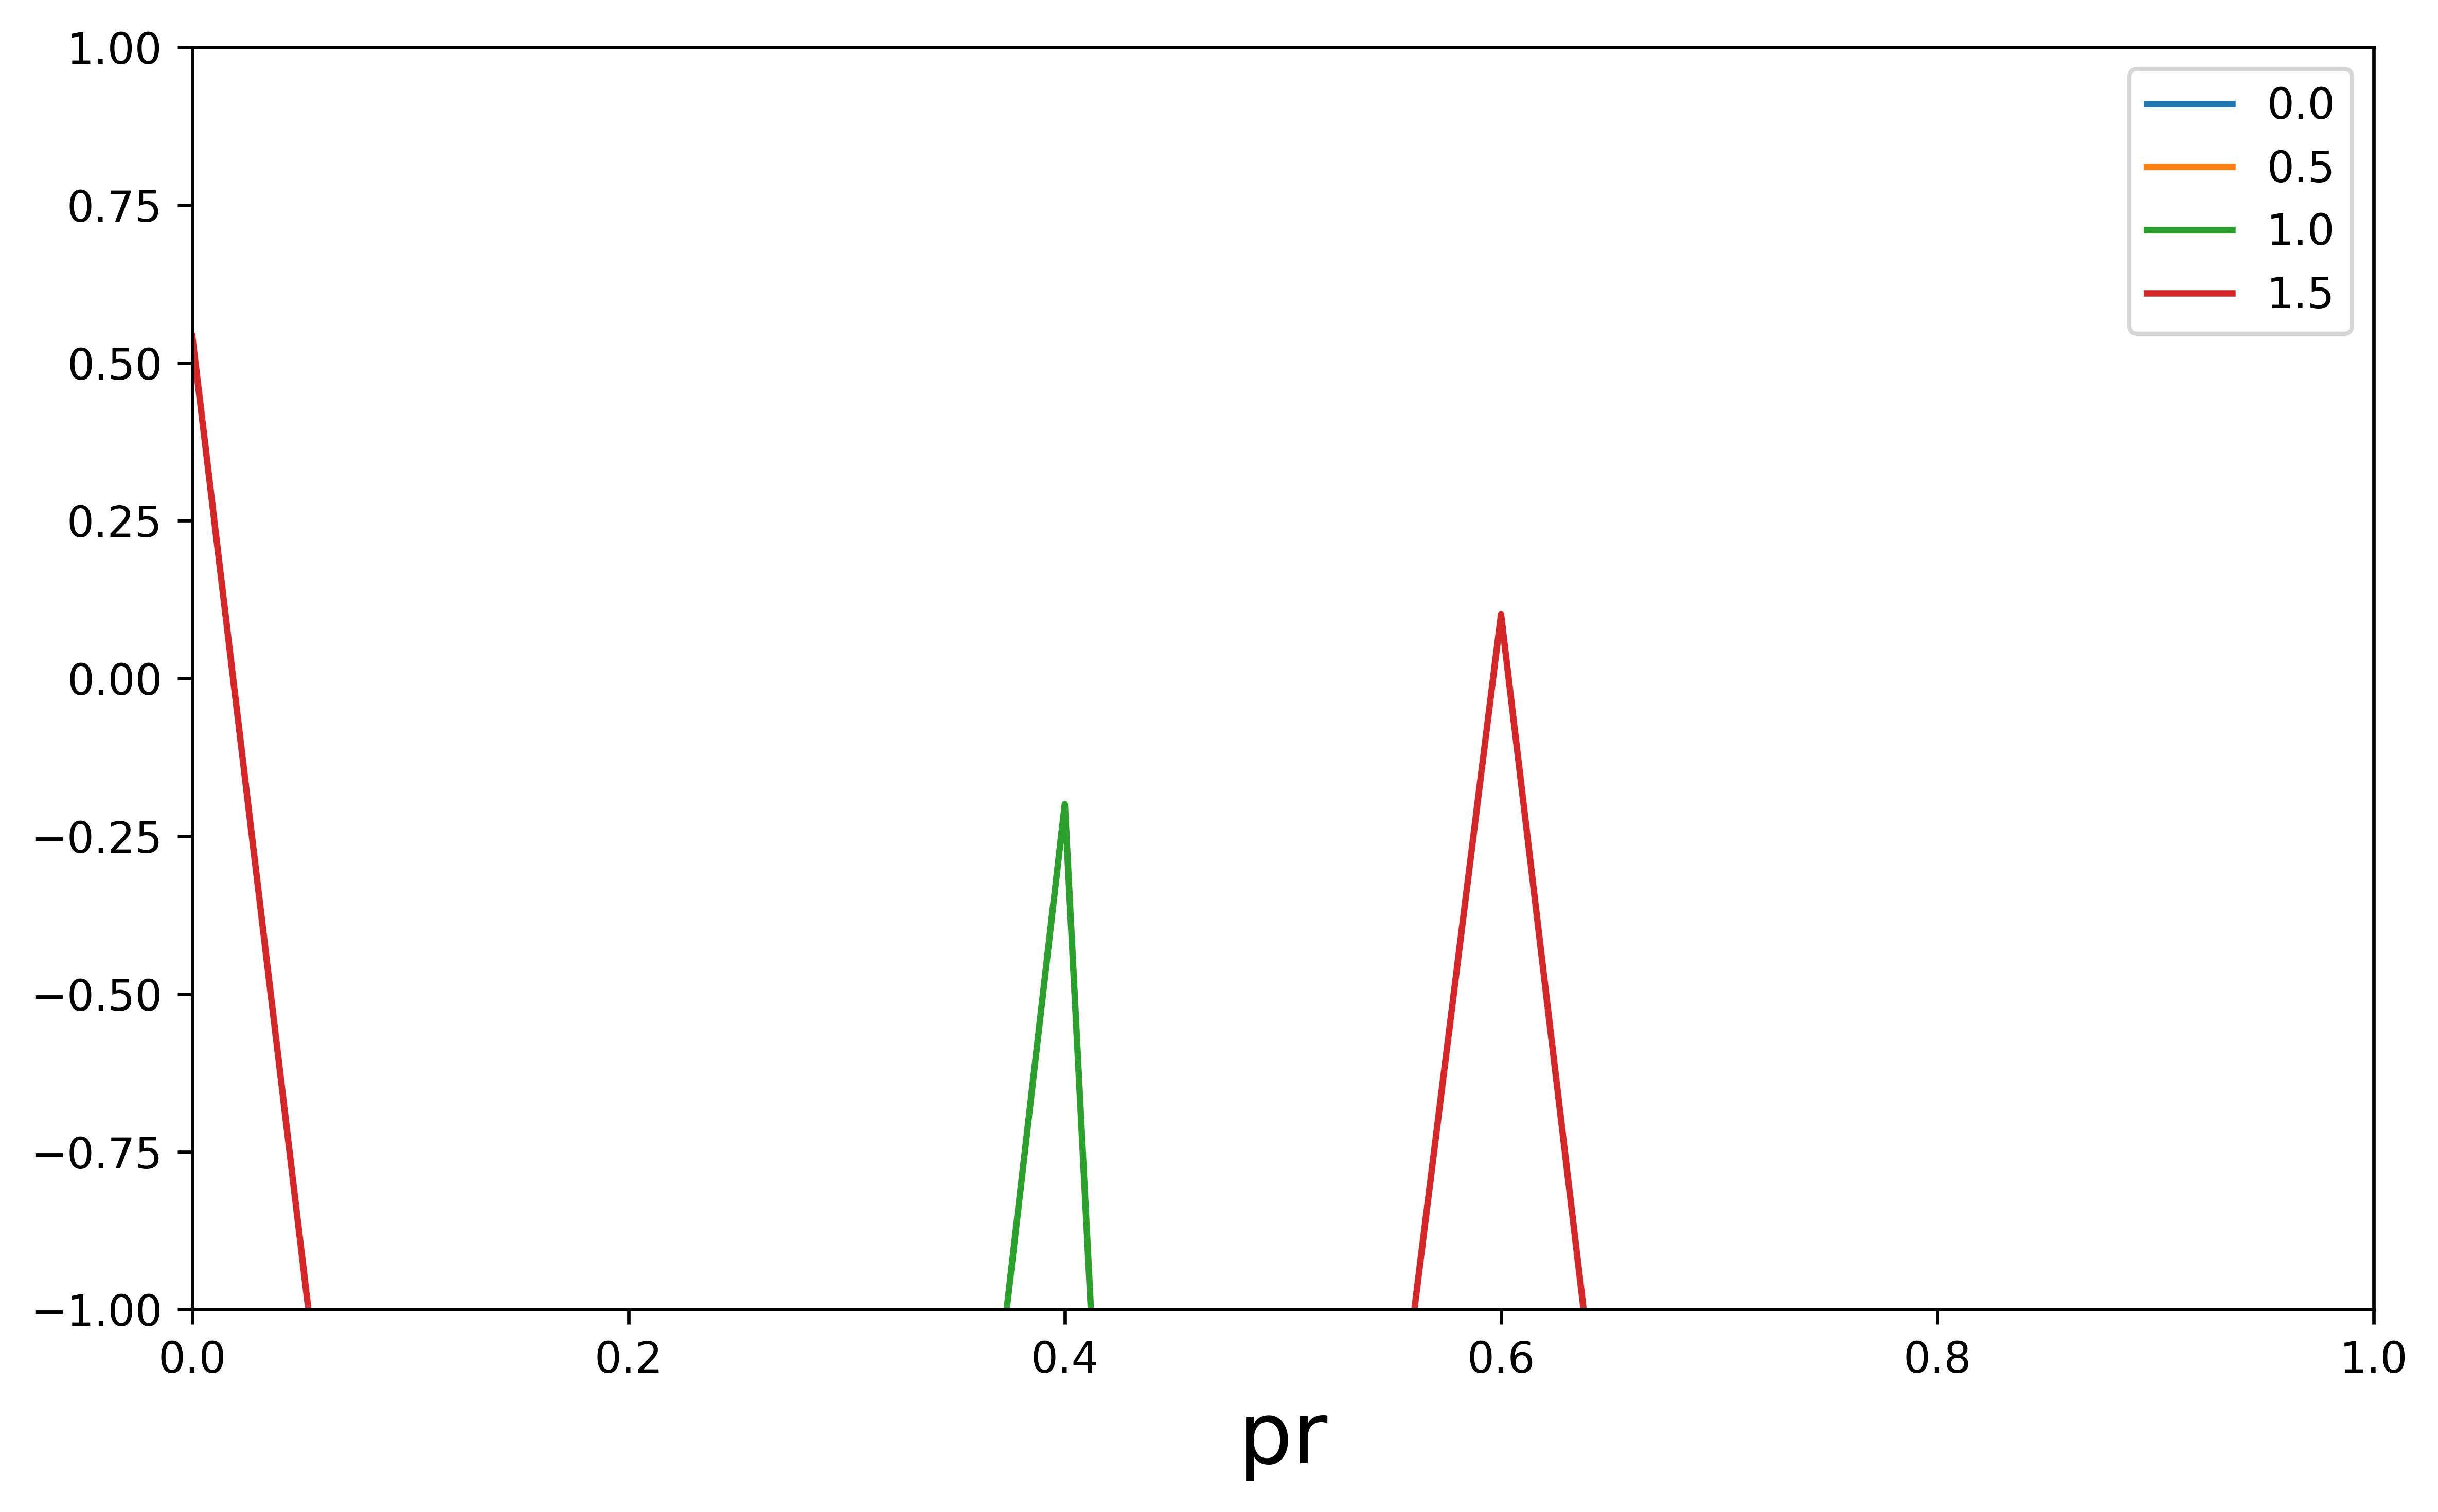

In [23]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
for key, group in results.groupby('gam'):
    group.plot('pr', "avghom_initial_2", label=key, ax = ax)
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()
plt.close()

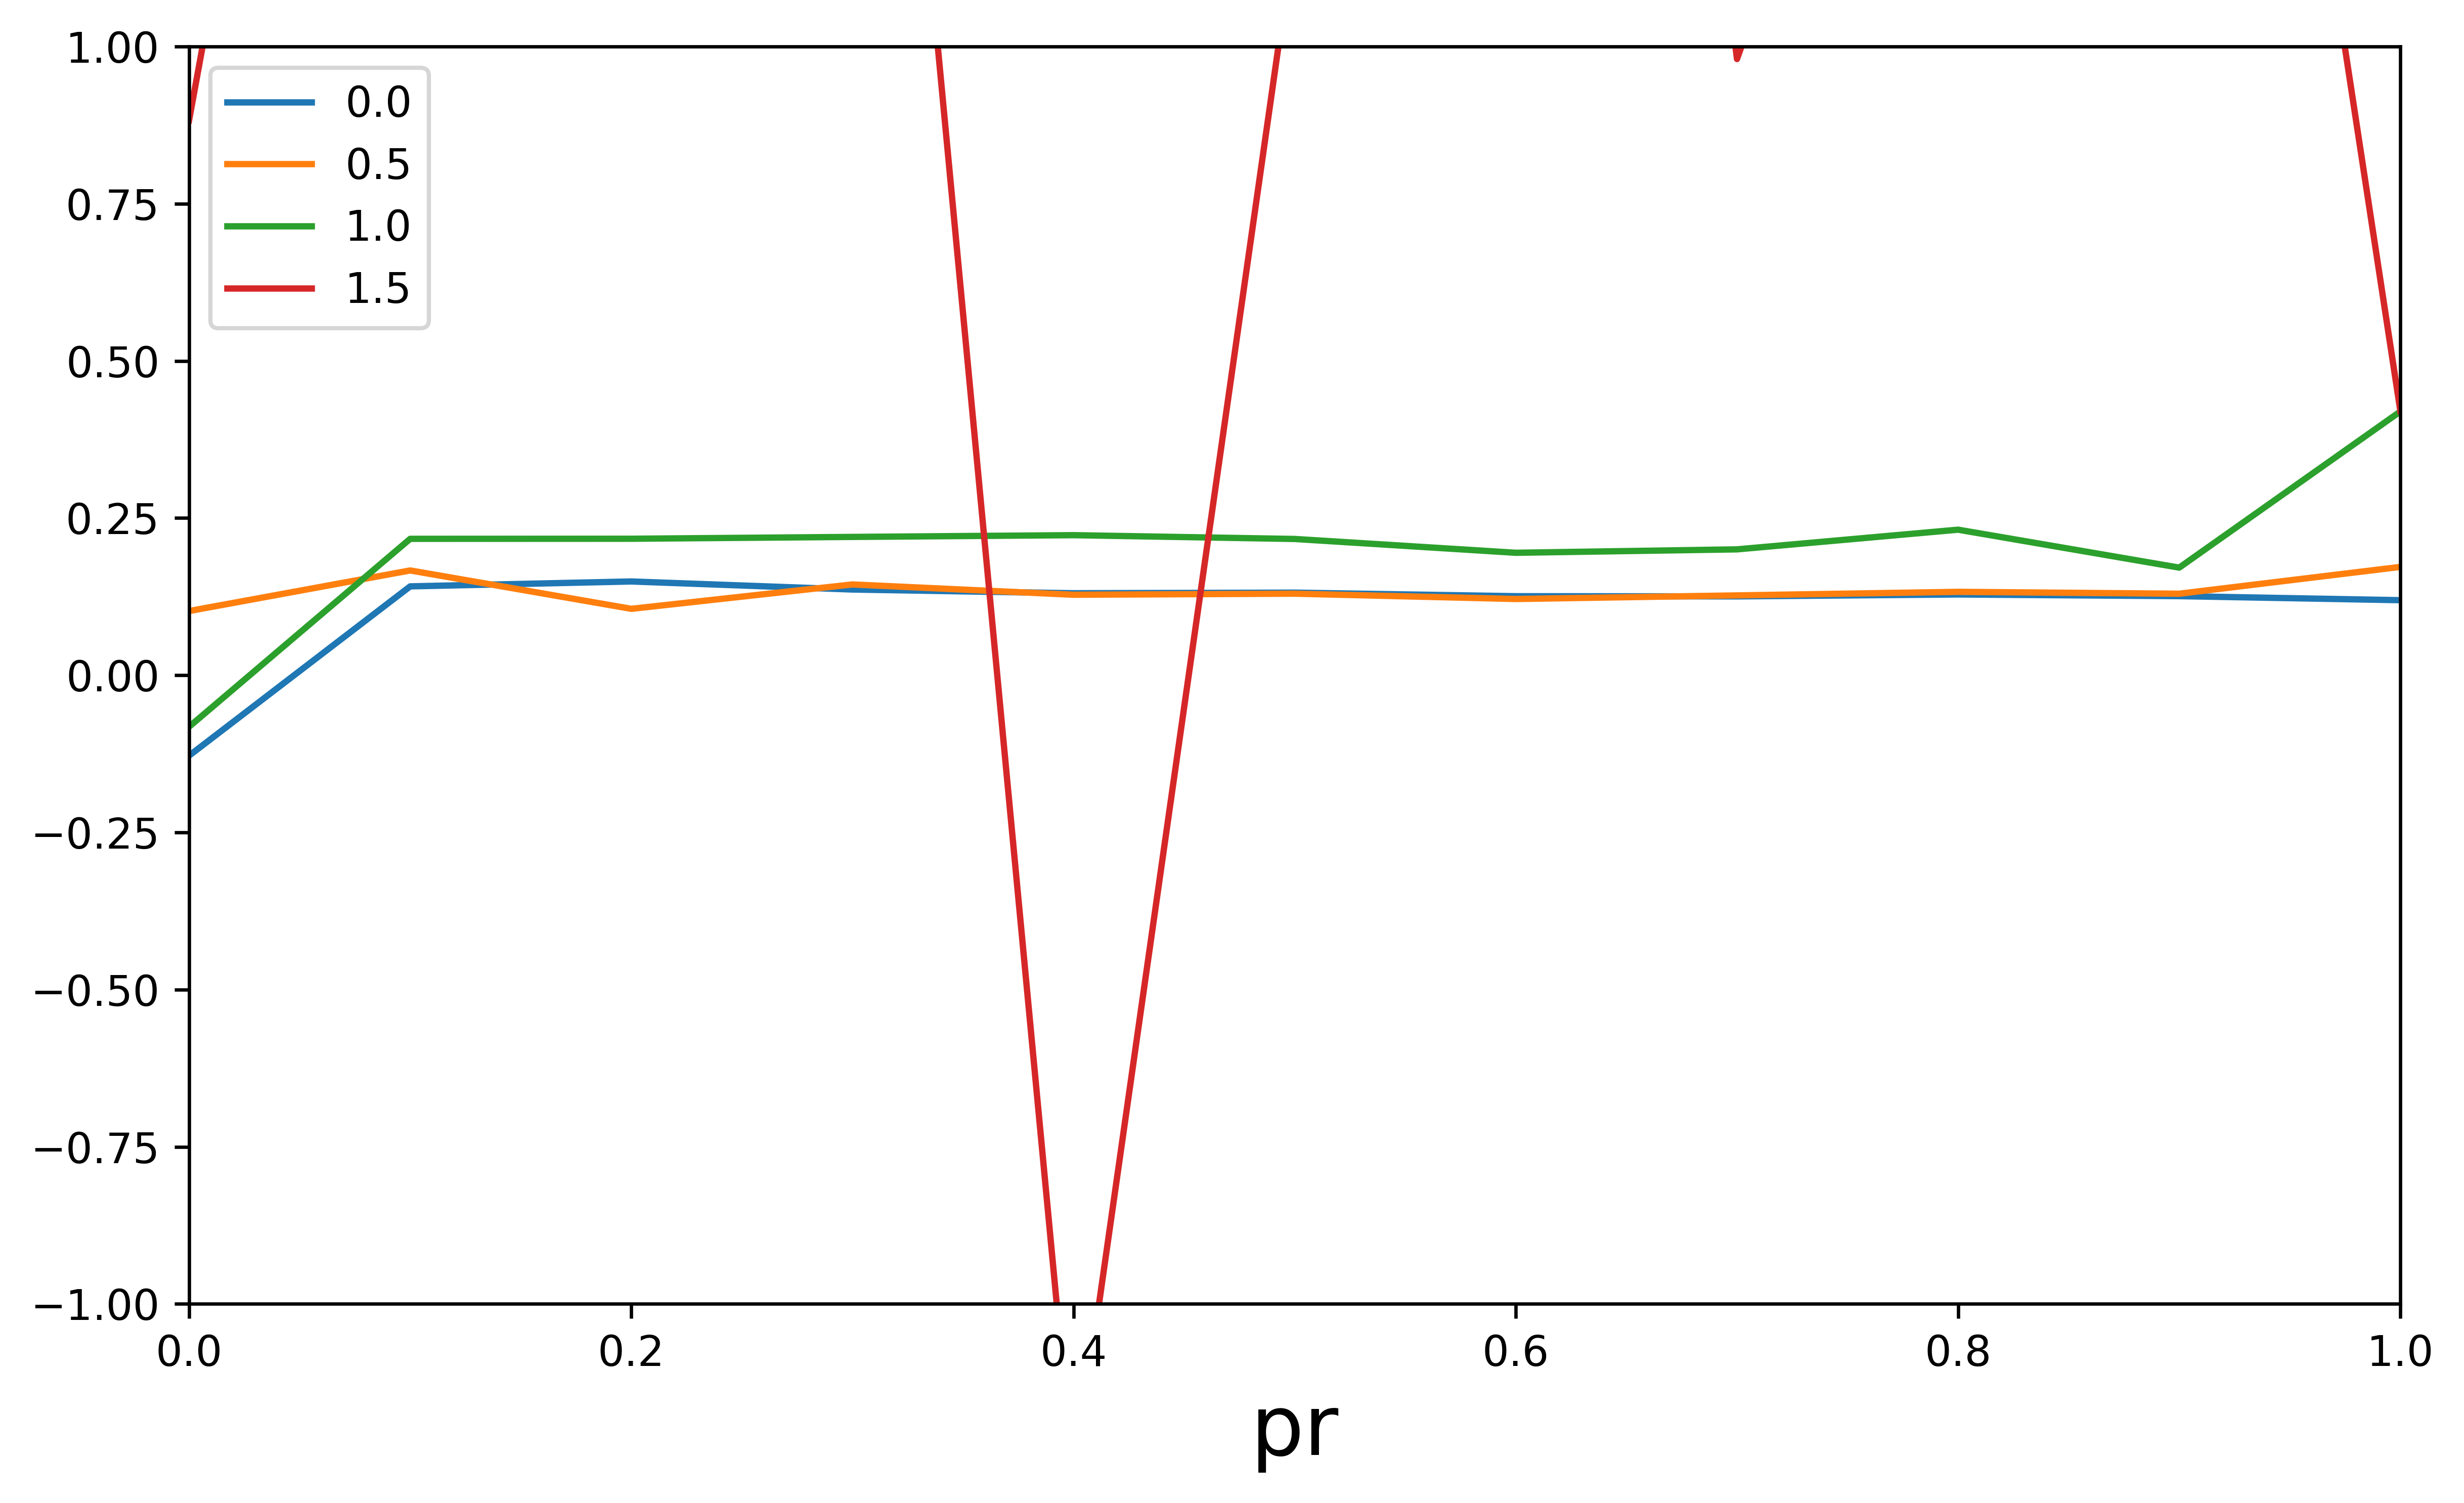

In [24]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
for key, group in results.groupby('gam'):
    group.plot('pr', "avghom_final_2", label=key, ax = ax)
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.tight_layout()
plt.ylim(-1, 1)
plt.show()
plt.close()

KeyError: 'avgass_final_2'

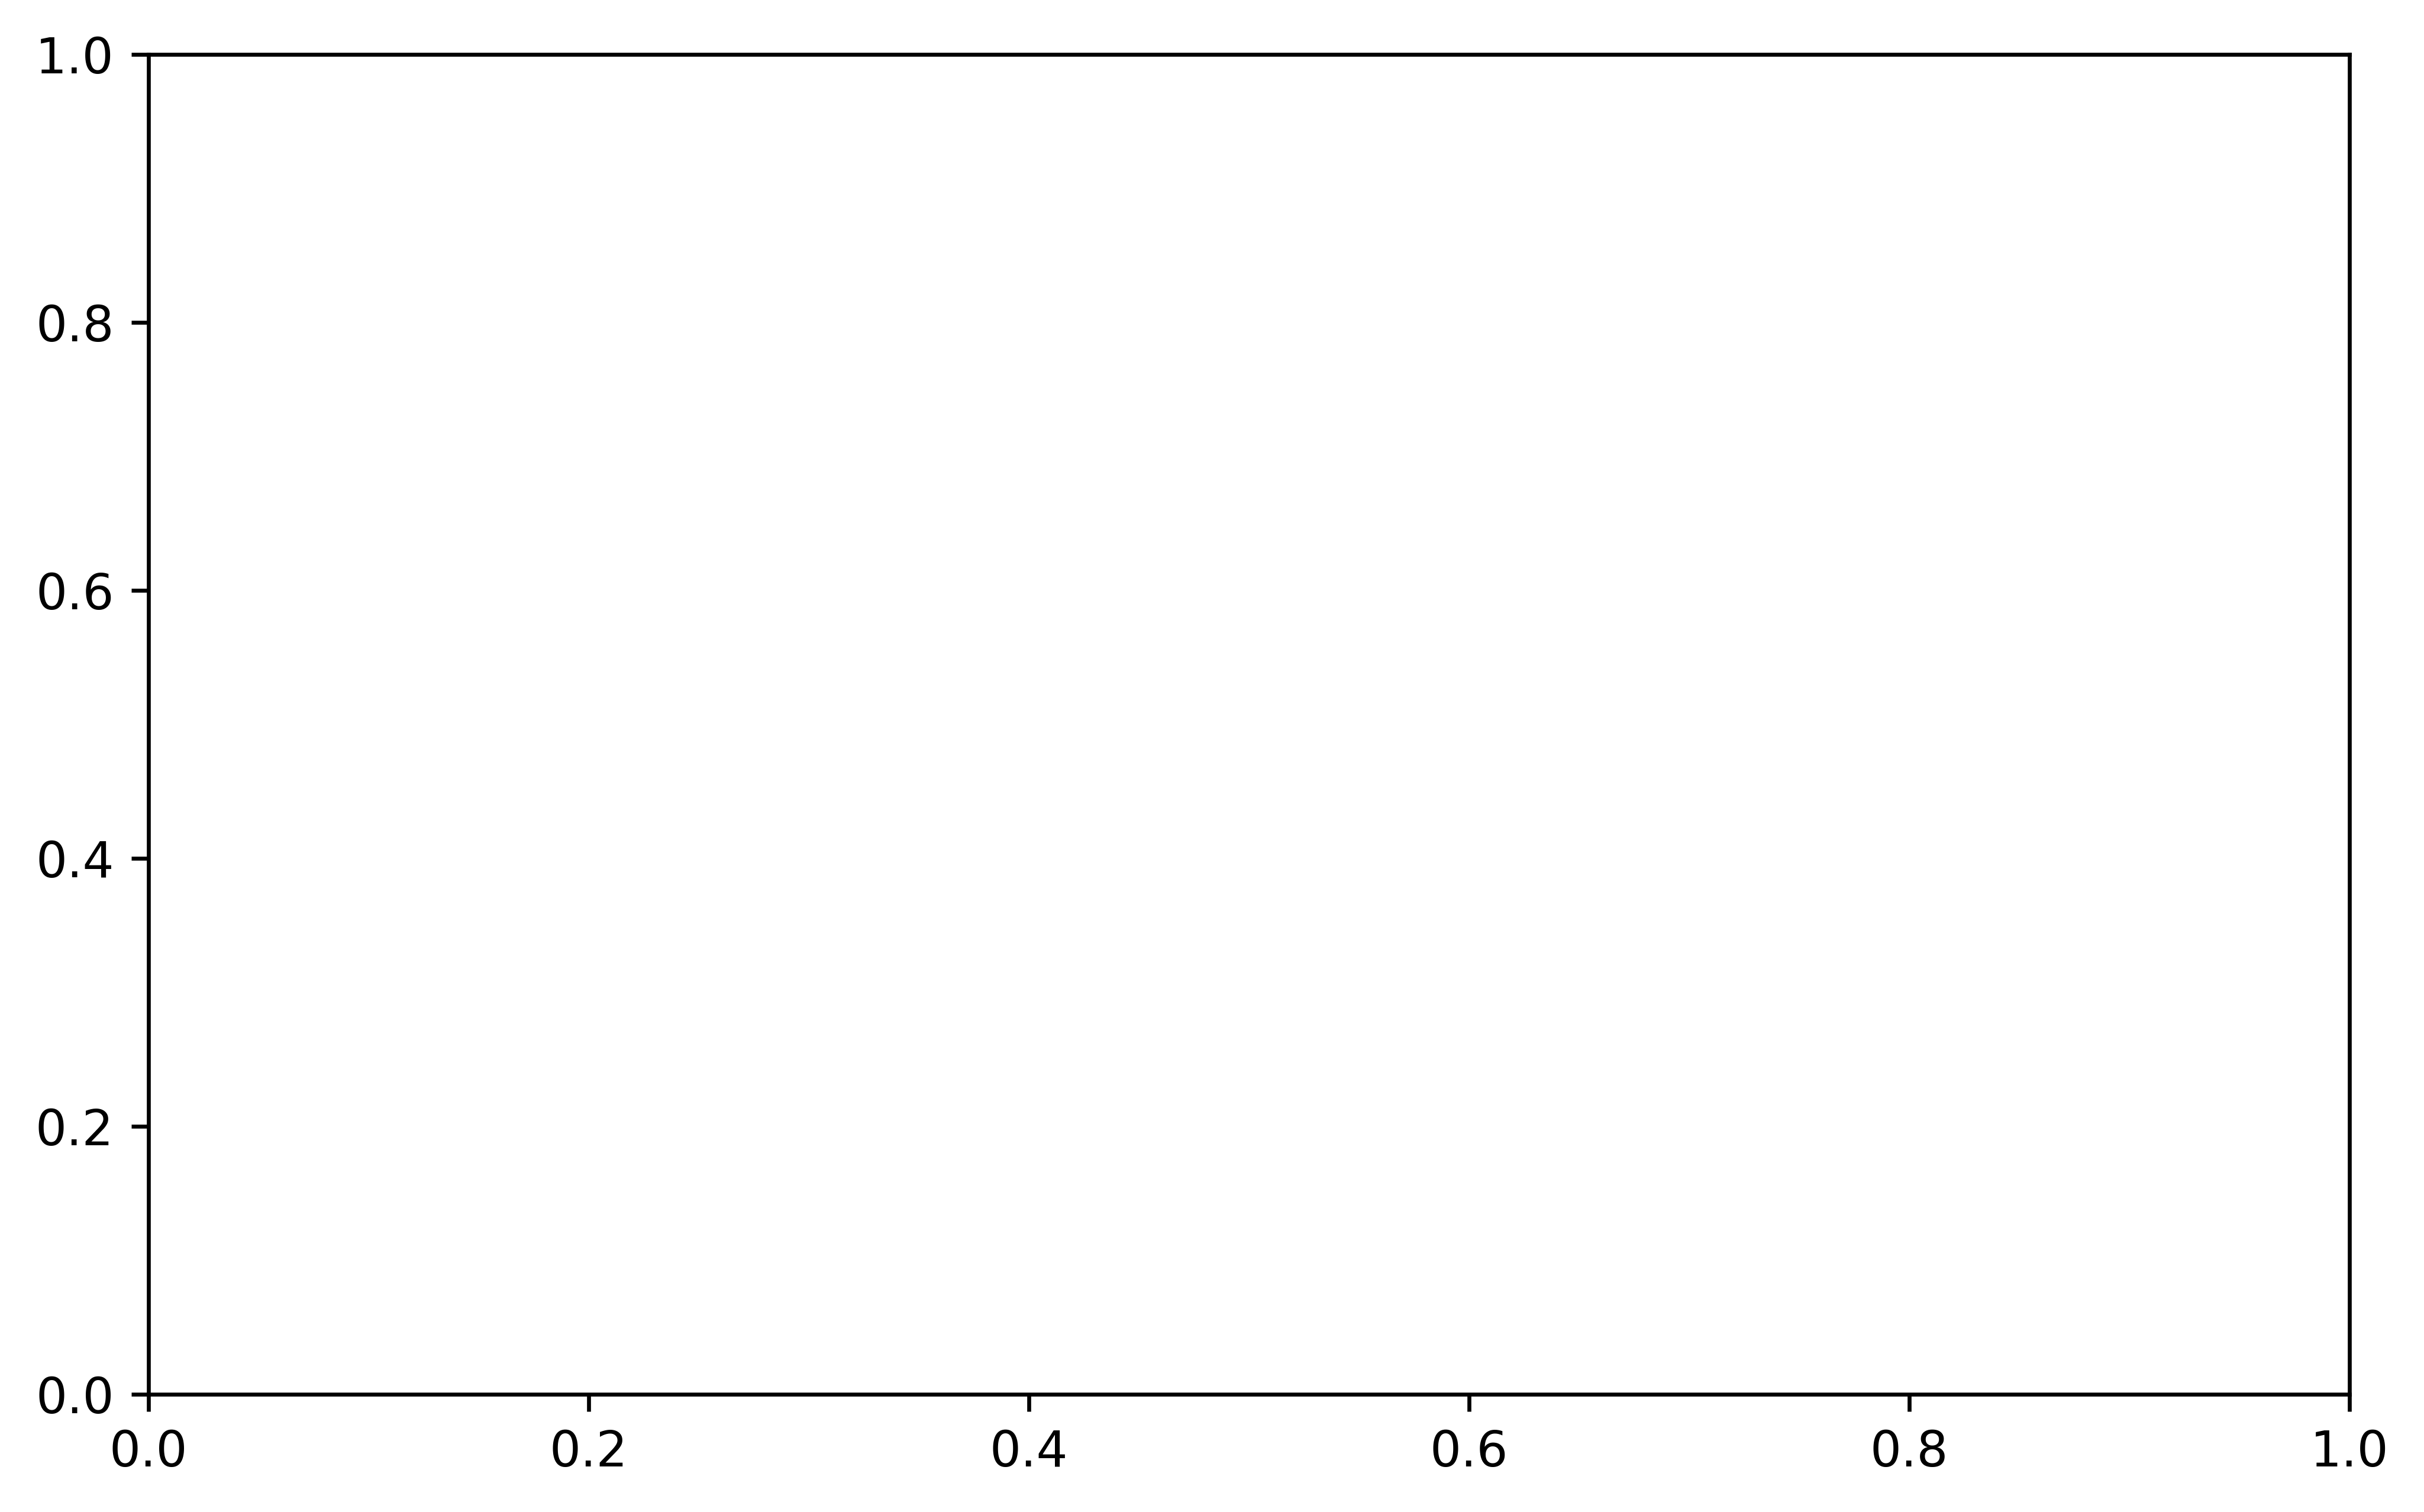

In [25]:
%matplotlib inline
results = results[results['gam']==0.0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
results.plot('pr', "avgass_final_2", ax = ax, marker = "s")
results.plot('pr', 'avgass_initial_2', ax=ax, marker = "s")
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
results = results[results['gam']==0.5]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
results.plot('pr', "avgass_final_2", ax = ax, marker = "s")
results.plot('pr', 'avgass_initial_2', ax=ax, marker = "s")
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
results = results[results['gam']==1.0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
results.plot('pr', "avgass_final_2", ax = ax, marker = "s")
results.plot('pr', 'avgass_initial_2', ax=ax, marker = "s")
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
%matplotlib inline
results = results[results['gam']==1.5]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
results.plot('pr', "avgass_final_2", ax = ax, marker = "s")
results.plot('pr', 'avgass_initial_2', ax=ax, marker = "s")
plt.xlabel(r'{}'.format("pr"), fontsize=20)   
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), dpi=600)
sns.scatterplot(data=results, x="avghom_initial_2", y="avghom_final_", hue="pr", style = "gam", palette="deep", ax=ax)
plt.ylim(-1,1)
plt.xlim(-1,1)

In [ ]:
results['diff'] = (results["avghom_final_2"] - results["avghom_initial_2"])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=600)
data = results.pivot("pr", "gam", "diff")
sns.heatmap(data=data, cmap='RdBu_r', cbar=True, fmt = ".2f", annot=True, annot_kws={"size": 10}, ax=ax)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), dpi=600)
data = results.pivot("pr", "gam", "avghom_final_2")
sns.heatmap(data=data, cmap='RdBu_r', cbar=True, fmt = ".2f", annot=True, annot_kws={"size": 10}, ax=ax)